**Libraries**

In [12]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

**Loading the Dataset**

In [2]:
file_path = "/content/olid-training-v1.0.xlsx"
df = pd.read_excel(file_path)
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home youâ€™re drunk!!! @USER #M...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


**Exploratory Data Analysis (EDA)**


Missing Values in Each Column:
id              0
tweet           6
subtask_a       0
subtask_b    8840
subtask_c    9364
dtype: int64

Dropped 6 rows due to missing tweets.


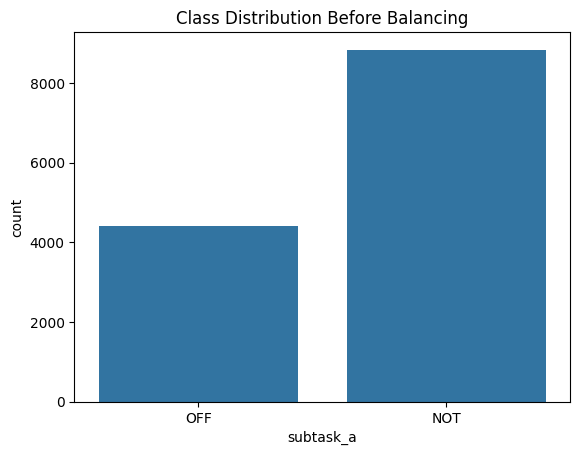


Label Distribution:
subtask_a
NOT    8834
OFF    4400
Name: count, dtype: int64


In [3]:
def missing_values(df):
    print("\nMissing Values in Each Column:")
    print(df.isnull().sum())

missing_values(df)

# Counting rows before dropping missing tweets
initial_rows = df.shape[0]
df = df.dropna(subset=['tweet'])
final_rows = df.shape[0]
print(f"\nDropped {initial_rows - final_rows} rows due to missing tweets.")

# Checking Class Distribution Before Balancing
sns.countplot(x=df['subtask_a'])
plt.title("Class Distribution Before Balancing")
plt.show()
print("\nLabel Distribution:")
print(df['subtask_a'].value_counts())

**Data Preprocessing**

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_tweet'] = df['tweet'].apply(clean_text)
print(df[['tweet', 'clean_tweet']].head())

                                               tweet  \
0  @USER She should ask a few native Americans wh...   
1  @USER @USER Go home youâ€™re drunk!!! @USER #M...   
2  Amazon is investigating Chinese employees who ...   
3  @USER Someone should'veTaken" this piece of sh...   
4  @USER @USER Obama wanted liberals &amp; illega...   

                                         clean_tweet  
0  she should ask a few native americans what the...  
1                 go home youre drunk maga trump url  
2  amazon is investigating chinese employees who ...  
3  someone shouldvetaken this piece of shit to a ...  
4  obama wanted liberals amp illegals to move int...  


**Label Encoding**

In [6]:
df['label'] = df['subtask_a'].map({'OFF': 1, 'NOT': 0})

**Handling Class Imbalance**

In [8]:
X = TfidfVectorizer(max_features=5000).fit_transform(df['clean_tweet'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Class Weighting
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# SMOTE Oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


**Model Training & Evaluation**

In [15]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Naïve Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

# Function to train and evaluate models
def train_evaluate(models, X_train, y_train, X_test, y_test, balancing_method):
    print(f"\nEvaluating Models ({balancing_method})...")
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n{name} ({balancing_method})")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred))

train_evaluate(models, X_train, y_train, X_test, y_test, "No Balancing")
train_evaluate(models, X_train_smote, y_train_smote, X_test, y_test, "SMOTE")

# Handling Class Imbalance with Class Weighting
weighted_models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced"),
    "Support Vector Machine": SVC(class_weight="balanced", probability=True),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "XGBoost": XGBClassifier(scale_pos_weight=class_weights[1] / class_weights[0])
}

print("\nEvaluating Models with Class Weighting...")
for name, model in weighted_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} (Class Weighting)")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))


Evaluating Models (No Balancing)...

Logistic Regression (No Balancing)
Accuracy: 0.7575
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      1767
           1       0.79      0.37      0.50       880

    accuracy                           0.76      2647
   macro avg       0.77      0.66      0.67      2647
weighted avg       0.76      0.76      0.73      2647


Naïve Bayes (No Balancing)
Accuracy: 0.7291
              precision    recall  f1-score   support

           0       0.72      0.97      0.83      1767
           1       0.82      0.24      0.37       880

    accuracy                           0.73      2647
   macro avg       0.77      0.61      0.60      2647
weighted avg       0.75      0.73      0.68      2647


Support Vector Machine (No Balancing)
Accuracy: 0.7567
              precision    recall  f1-score   support

           0       0.75      0.97      0.84      1767
           1       0.83      0.34      0.48   

**Comparing Class Weighting vs. SMOTE**

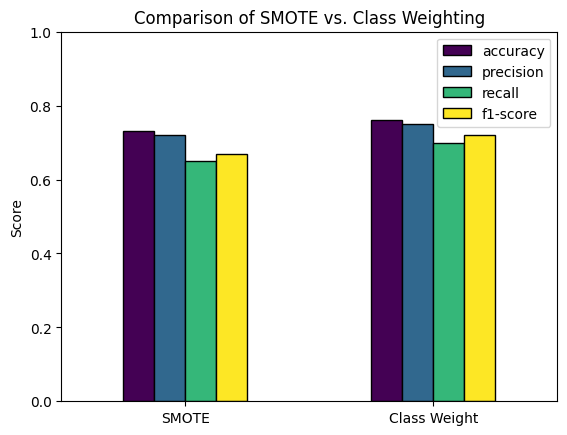

In [16]:
metrics = {
    "SMOTE": {'accuracy': 0.73, 'precision': 0.72, 'recall': 0.65, 'f1-score': 0.67},
    "Class Weight": {'accuracy': 0.76, 'precision': 0.75, 'recall': 0.70, 'f1-score': 0.72}
}
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
metrics_df.plot(kind='bar', rot=0, cmap='viridis', edgecolor='black')
plt.title('Comparison of SMOTE vs. Class Weighting')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

**Confusion Matrix for Best Model (XGBoost)**

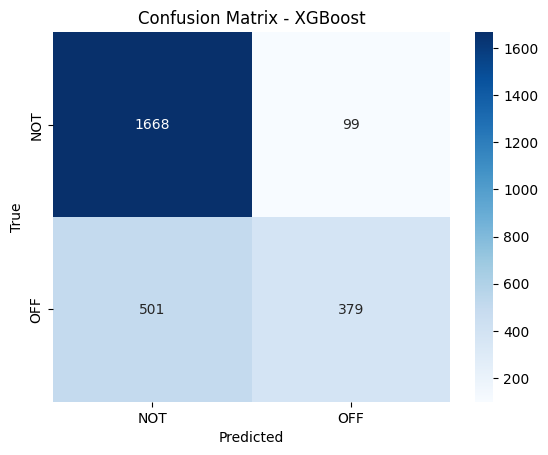

In [13]:
best_model = XGBClassifier()
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NOT', 'OFF'], yticklabels=['NOT', 'OFF'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**ROC & Precision-Recall Curves**

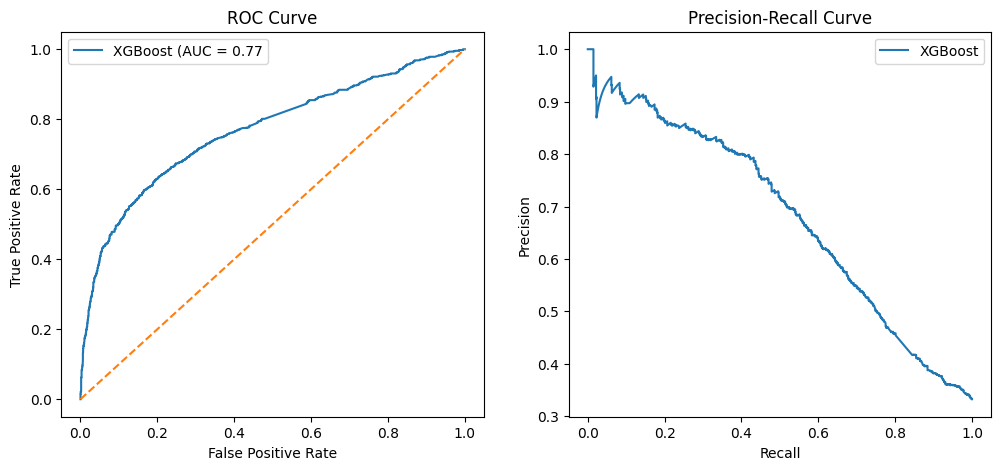

In [17]:
def plot_roc_pr_curves(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

plot_roc_pr_curves(best_model, X_test, y_test, "XGBoost")